<a href="https://colab.research.google.com/github/jouvetg/igm/blob/main/notebooks/IGM_aletsch_invert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <h1 align="center" id="title">IGM aletsch invert </h1>

This tutorial aims to present a full modelling workflow of a mountain glacier using the Instructed Glacier Model (IGM) including the step of diagnostic data assimilation (inverse modelling) and prognostic glacier evolution (forward modelling).


In the inverse modelling, the goal is to seek for optimal variables (red variables, such ice ice thickness, ice viscosity, sliding coefficient) such that the resulting ice flo speed, ice thickness and surface ice elevation fits as good as poosible observation variables (blue)

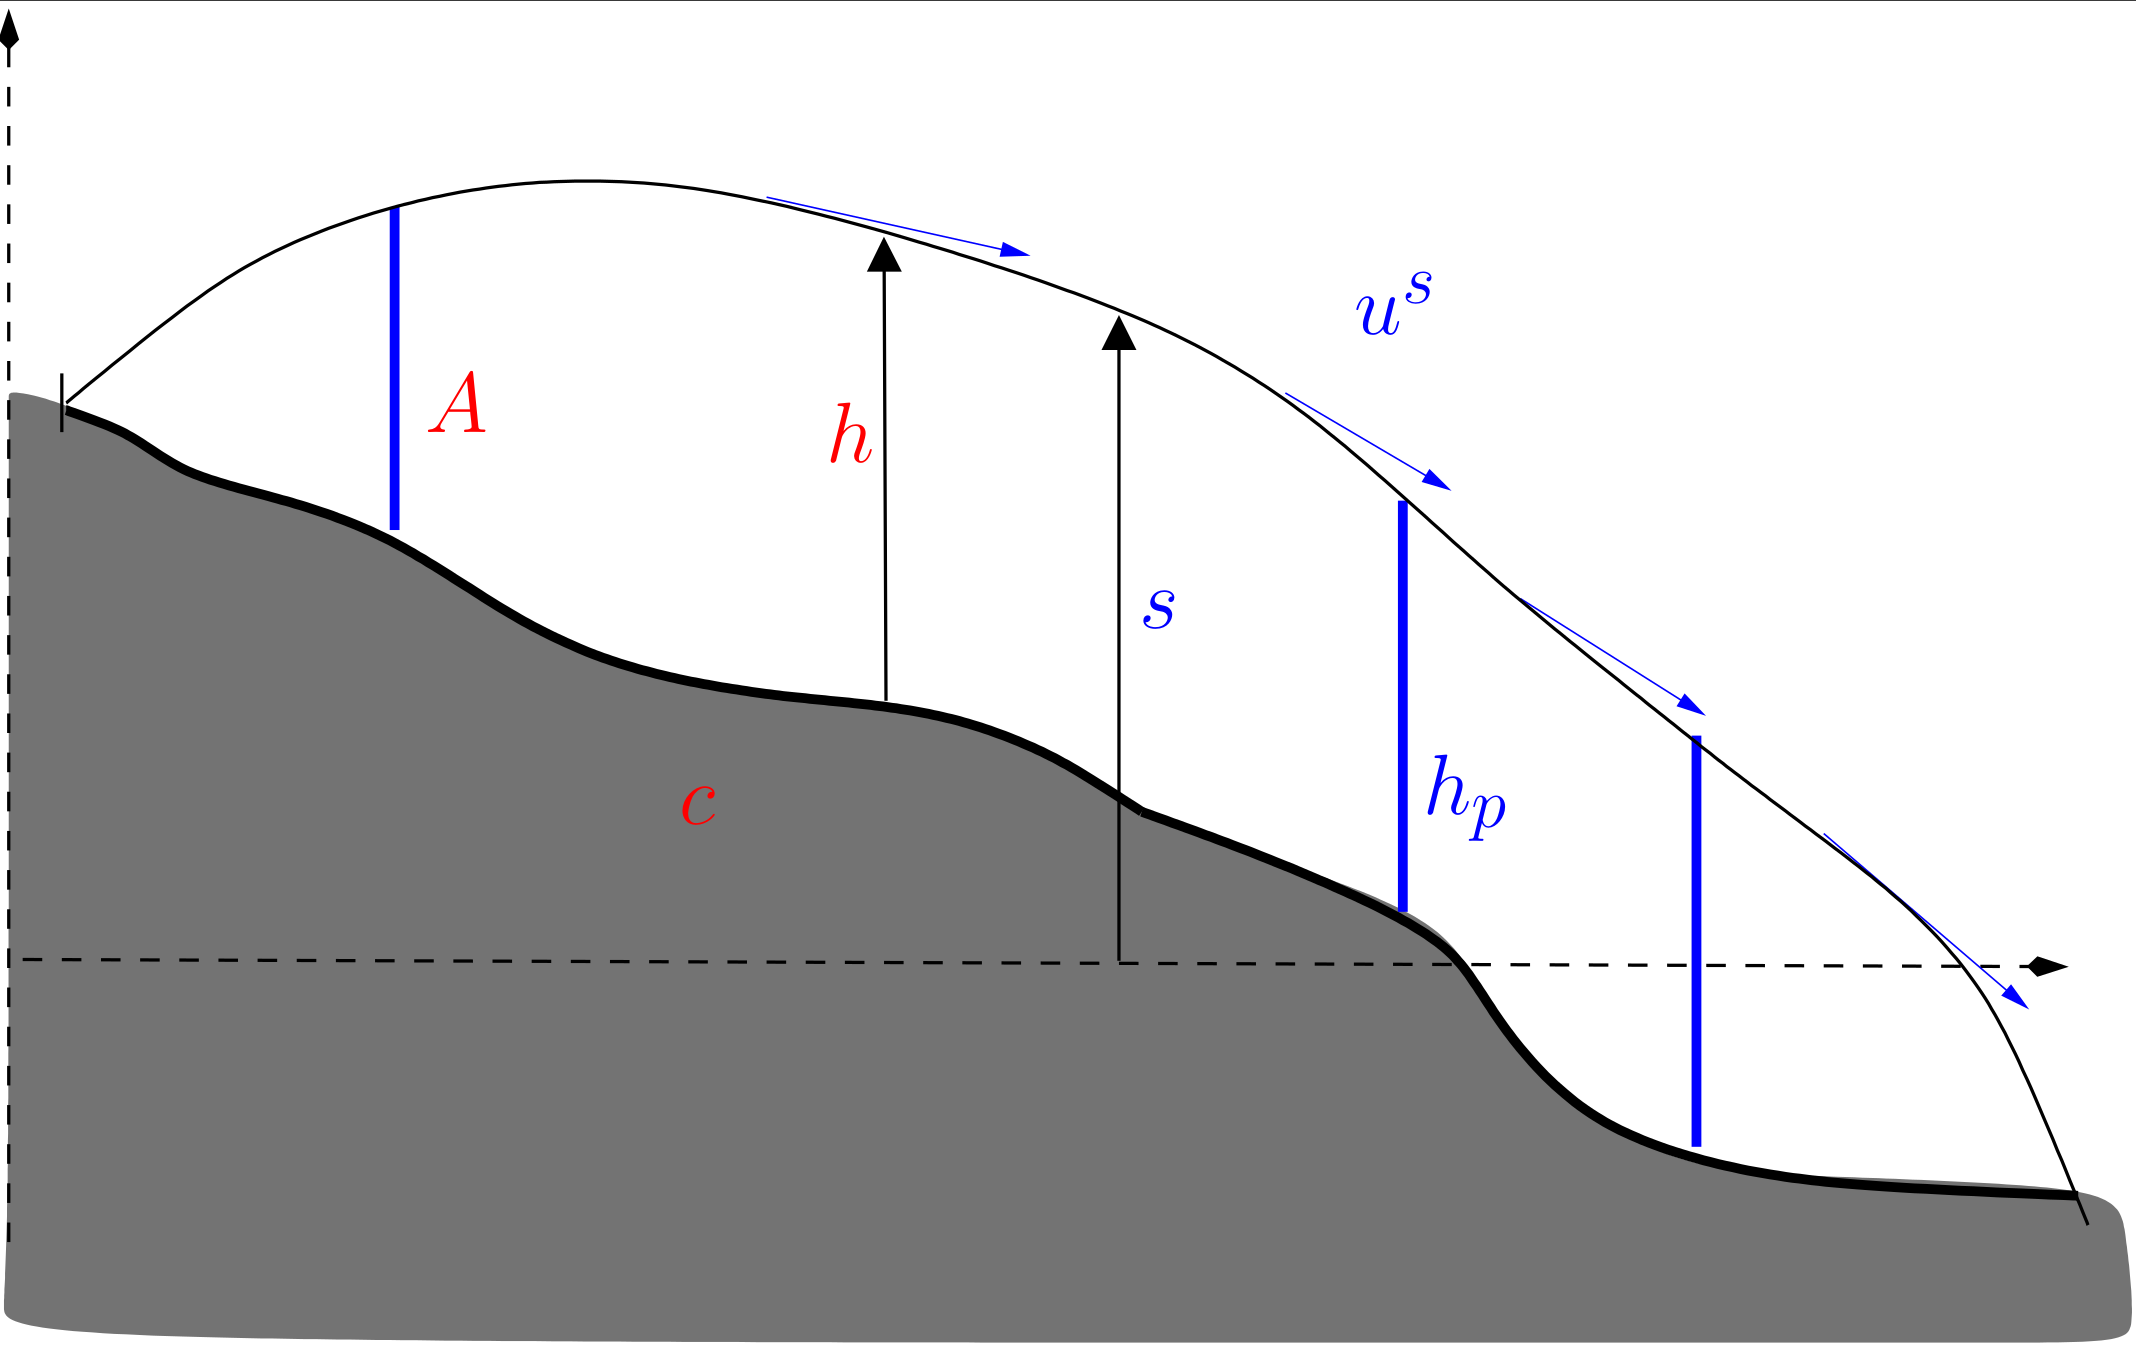

First we need to download the IGM code, ice flow emulator, and input data. Input files include geological inputs (geology*.nc).

In [ ]:
# get the core source of igm (in igm.py)
!wget -nv -O igm.py https://raw.githubusercontent.com/jouvetg/igm/main/src/igm.py

# get geological input data
!wget -nv -O observation.nc https://raw.githubusercontent.com/jouvetg/igm/main/examples/aletsch-invert/observation.nc

# get the ice flow DL-emulator
!apt install -qq subversion
!svn export https://github.com/jouvetg/igm/trunk/model-lib/f12_cfsflow_GJ_21_a
#!svn export https://github.com/jouvetg/igm/trunk/model-lib/f17_pismbp_GJ_22_a


Next, we import the main libraries, define an objet 'igm', define input files, custumize parameters, and run the inversion. IGM will output the list of parameters in use (which are the default + the one custumized here). Here you may change between Aletsch (rgi=1449) or Mer de Glace (rgi=3642).

In [ ]:
# import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys 
sys.argv = ['']  # this is absolutly necessary in Jupyter notebook

# import igm libary
from igm import igm 

# create an object igm, which contains variable and functions
igm=igm()

# define working directory and input files
igm.config.working_dir            = ''                     
igm.config.iceflow_model_lib_path = 'f12_cfsflow_GJ_21_a' # this direct the DL ice flow emaultor
igm.config.observation_file       = 'observation.nc' # this is the main input file
 
igm.config.opti_output_freq       =   50     # Frequency for output
igm.config.opti_nbitmax           =   500     # Number of iterations for the optimization 

igm.config.opti_regu_param_thk           = 10.0  # weight for the regul. of thk
igm.config.opti_regu_param_strflowctrl   = 1.0   # weight for the regul. of strflowctrl (NON DEFAULT)

igm.config.opti_step_size                = 0.005 # this is the step size while optimiting

igm.config.opti_smooth_anisotropy_factor = 0.2   # Smooth anisotropy factor

igm.config.opti_usurfobs_std             = 5.0   # Tol to fit top ice surface
igm.config.opti_velsurfobs_std           = 3.0   # Tol to fit surface speeds
igm.config.opti_thkobs_std               = 5.0   # Tol to fit ice thk profiles
igm.config.opti_strflowctrl_std          = 5.0   # Tol to fit strflowctr
igm.config.opti_divfluxobs_std           = 1.0   # Tol to fit the flux divergence (NON DEFAULT)

# This combination works when there exist observed ice thickness data
igm.config.opti_control = ['thk','usurf','strflowctrl']
igm.config.opti_cost    = ['velsurf','icemask','usurf','divfluxfcz','thk'] 
#
# Otherwise, whithout this constraint, you must remove one controll as well, typically strflowctrl
#igm.config.opti_control = ['thk','usurf']
#igm.config.opti_cost    = ['velsurf','icemask','usurf','divfluxfcz']

igm.run_opti() # this runs the inversion modelling to seek for controls that fit best data defined in cost

We have seen the costs associated to fit in velicity (COST_U), fit in ice thickness (COST_H), fit in divergence of the flux (COST_D), fit in top ice surface (COST_S), and the two regularization terms decreasing.

Note, let's plot the initial and optimized ice thickness, and check the RMS & STD of the error with respect to thickness profile (if any). Both RMS and STD should have been reduced.

In [ ]:
igm.plot_opti_diff('optimize.nc','thk', plot_live=True)

Let's check the initial and final surface velocity magnitude, as well the target, together with RMS and STD of the error between modelled and observed/target. Boht RMS and STD should have been reduced.

In [ ]:
igm.plot_opti_diff('optimize.nc','velsurf_mag', plot_live=True) 

This shows the divergence of the flux prior and after the optimization. As the divergence of the flux was constrained to be smooth (or equivalently to fit its linear regression). The divergence of the flux should be les noisy after the optimization (then the shock at initiatlisatin must be reduced too).

In [ ]:
igm.plot_opti_diff('optimize.nc','divflux', plot_live=True)

If you have included the top ice surface as control, you may check the difference between initial state of optimized state, that should not change it dramatically, but still giving some slack in the system help other variables
to fit their targets.

In [ ]:
igm.plot_opti_diff('optimize.nc','usurf', plot_live=True)

If strflowctrl was included as control, you may check the initial and final/optimzed state here.

In [ ]:
igm.plot_opti_diff('optimize.nc','strflowctrl', plot_live=True)

For runing the model forward, we extract an approximation of ELA and mass balance gradient values if the glacier was in a steady state. For that we do a linear regression between the surface altitude and the divergence of the flux (plotted).

In [ ]:
ACT = (igm.thk>1.0)&(np.abs(igm.divflux)>0.1)          
from scipy import stats              
res = stats.linregress(igm.usurf[ACT],igm.divflux[ACT])  
ELA = - res.intercept/res.slope
gradmb = res.slope
plt.imshow(igm.divflux,origin='lower',vmin=-10,vmax=10) ; plt.colorbar()
print('ELA :',ELA,' gradmb :',gradmb)

Now that we have optimized thickness, surface and strflowctrl, we can run our model forward in time, e.g. until 2100. For that we define a mas balance with a increasing/decreasing ELA.

In [ ]:
# import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys 
sys.argv = ['']  # this is absolutly necessary in Jupyter notebook

# import the igm library
from igm import *

# We augment igm with a custumized smb function that takes ELA and gradmb previously defined
class igm(igm):

    def update_smb_mysmb(self):
        """
            mass balance 'mysmb'
        """

        DELA = 0 # Increase ELA by 800 until 2100

        ela = self.ELA + DELA*(self.t-self.config.tstart)/(self.config.tend-self.config.tstart)
        smb = (self.usurf - ela)*self.gradmb
        smb = tf.where(self.icemask>0.5, smb, -10 )
        self.smb.assign( smb )
 
# create an object igm, which contains variable and functions
igm = igm() 

# ELA and gradmb values needs to be accessible from the class igm
igm.ELA    = ELA
igm.gradmb = gradmb

igm.config.working_dir              = '' 
igm.config.iceflow_model_lib_path   = 'f12_cfsflow_GJ_21_a'  # this direct the DL ice flow emaultor
igm.config.geology_file             = 'geology.nc' # this time we take the (shortly) optimized geology data

igm.config.tstart            = 2017    # our data (glacier surface DEM, speeds) are about from that year
igm.config.tend              = 2100    # we run the model until 2100
igm.config.tsave             = 2       # we save output each 2 years
igm.config.cfl               = 0.25    # the CFL number determines the time step, it should be < 1, reduce it further if unstability occurs.
igm.config.type_mass_balance = 'mysmb' # we have to select the SMB defined before.

igm.run()

For vizualization, we make an animation plotting variable of interest (ice thickness is thk, or surface velocity magnitude is velsurf_mag) from the writen output file ex.nc. Once done, just click on mp4 animation created in the folder to vizulize them.

In [10]:
igm.animate_result('ex.nc','thk',save=True)
igm.animate_result('ex.nc','velsurf_mag',save=True)

In this last experience, we include a real climate that generate monthly temperature and precipitation, and a mass balance function to translate these variable in terms of effective surface mass balance. The SMB can be a PDD, but here we use for illustration a Neural Netowrk trained from climate and SMB data.

You may clean behind you

In [12]:
# clean all
! rm -r f12_cfsflow_GJ_21_a  __pycache__ smb1_meteoswissglamos_GJ_21_a f17_pismbp_GJ_22_a
! rm *.nc  *.py *.dat *.txt igm-run-parameters.txt *.mp4 *.dat *.png

rm: cannot remove 'smb1_meteoswissglamos_GJ_21_a': No such file or directory
rm: cannot remove 'f17_pismbp_GJ_22_a': No such file or directory
rm: cannot remove 'igm-run-parameters.txt': No such file or directory
rm: cannot remove 'costs.dat': No such file or directory
rm: cannot remove 'rms_std.dat': No such file or directory
rm: cannot remove 'strflowctrl.dat': No such file or directory
rm: cannot remove 'tcompoptimize.dat': No such file or directory
rm: cannot remove 'volume.dat': No such file or directory
